# Importing important libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# Data loading

In [12]:
data = pd.read_csv('my_project/train.csv', encoding="ISO-8859-1")

data.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


# Data cleaning

### Creating a set of stopwords

In [2]:
import nltk
nltk.data.path = ['/Users/prebrar/astralgit/astral/astral/processing/nltk_data']
from nltk.corpus import stopwords

STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

### Creating all the functions required for cleaning data: lower casing, appostrophe Lookup, removing links, parsing hashtags, parsing mentions

In [ ]:
APPOSTROPHES = {
    "don't"   : "do not",
    "won't"   : "will not",
    "it's"    : "it is",
    "can't"   : "can not",
    "i'll"    : "i will",
    "i've"    : "i have",
    "you're"  : "you are",
    "didn't"  : "did not",
    "she's"   : "she is",
    "they're" : "they are",
    "we're"   : "we are",
    "you've"  : "you have",
    "aren't"  : "are not",
    "she'd"   : "she would",
    "he'd"    : "he would",
    "let's"   : "let us",
    "we've"   : "we have",
    "couldn't": "could not",
    "who's"   : "who is",
    "i'd"     : "i would",
    "i'm"     : "i am",
    "you'll"  : "you will",
    "isn't"   : "is not",
    "that's"  : "that is",
    "wouldn't": "would not",
    "doesn't" : "does not",
    "there's" : "there is",
    "we'll"   : "we will",
    "dont"    : "do not"
    }


def appostropheLookup(tweet):
    words = tweet.split()
    reformed = [APPOSTROPHES[word] if word in APPOSTROPHES else word for word in words]
    reformed = " ".join(reformed)
    return reformed


def removeLinks(tweet):
    links_re = re.compile("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)")
    tweet = links_re.sub(" ",tweet)
    tweet = ' '.join(tweet.split())
    return tweet



# Returns a list of common english terms (words)
def initialize_words():
    content = None
    with open('my_project/words_alpha.txt') as f: # A file containing common english words
        content = f.readlines()
    return [word.rstrip('\n') for word in content]


def parse_sentence(sentence, wordlist):
    new_sentence = "" # output    
    terms = sentence.split()    
    for term in terms:
        if term[0] == '#': # this is a hashtag, parse it
            new_sentence += parse_tag(term, wordlist)
        else: # Just append the word
            new_sentence += term
        new_sentence += " "

    return new_sentence 


def parse_tag(term, wordlist):
    words = []
    # Remove hashtag, split by dash
    tags = term[1:].split('-')
    for tag in tags:
        word = find_word(tag, wordlist)    
        while word != None and len(tag) > 0:
            words.append(word)            
            if len(tag) == len(word): # Special case for when eating rest of word
                break
            tag = tag[len(word):]
            word = find_word(tag, wordlist)
    return " ".join(words)

def find_word(token, wordlist):
    i = len(token) + 1
    while i > 1:
        i -= 1
        if token[:i] in wordlist:
            return token[:i]
    return None 


# Creating a preprocessor function to call all the the individual functions for cleaning the data

In [7]:
def preprocess(tweet):
    clean_tweet = tweet
    
    clean_tweet = removeLinks(clean_tweet)
    
    wordlist = initialize_words()
    
    clean_tweet = parse_sentence(clean_tweet, wordlist)
    
    mention_finder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    clean_tweet = mention_finder.sub("@MENTION", clean_tweet)
    
    clean_tweet = clean_tweet.lower()
     
    clean_tweet = appostropheLookup(clean_tweet)
    
    return clean_tweet

## Pie Chart (Positive Tweets vs Negative Tweets )

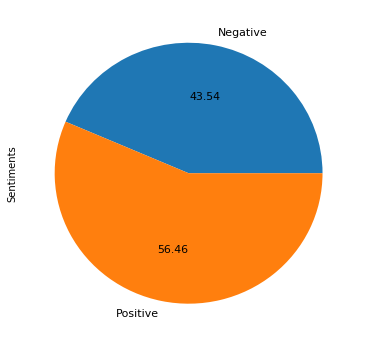

In [70]:
# We obtain all possible sources:
sentiments = []
for sentiment in data['Sentiment']:
    if sentiment not in sentiments:
        sentiments.append(sentiment)
        
percent = np.zeros(len(sentiments))

for sentiment in data['Sentiment']:
    for index in range(len(sentiments)):
        if sentiment == sentiments[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
pie_chart = pd.Series(percent, index=sentiments,  name='Sentiments')
pie_chart.plot.pie(fontsize=11, autopct='%.2f', labels = list(['Negative', 'Positive']),figsize=(6, 6));

## Generating a word cloud with top words

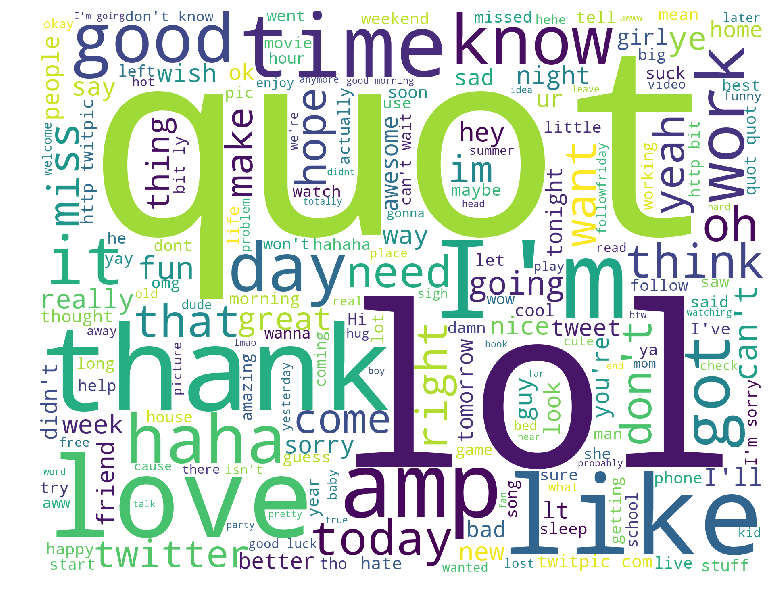

In [60]:
from wordcloud import WordCloud

# join tweets to a single string
words = ' '.join(data['SentimentText'])

no_urls_no_tags = " ".join([word for word in words.split()])

wordcloud = WordCloud(
                      stopwords=STOPLIST,
                      background_color='white',
                      width=1800,
                      height=1400
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### As a next step I separated the Positive and Negative tweets of the training set in order to easily visualize their contained words.

In [42]:
print(data.dtypes)

ItemID            int64
Sentiment         int64
SentimentText    object
dtype: object


In [71]:
data_pos = data[ data['Sentiment'] == 1]
data_pos = data_pos['SentimentText']
data_neg = data[ data['Sentiment'] == 0]
data_neg = data_neg['SentimentText']

def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPLIST,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Top Positive words

Positive words


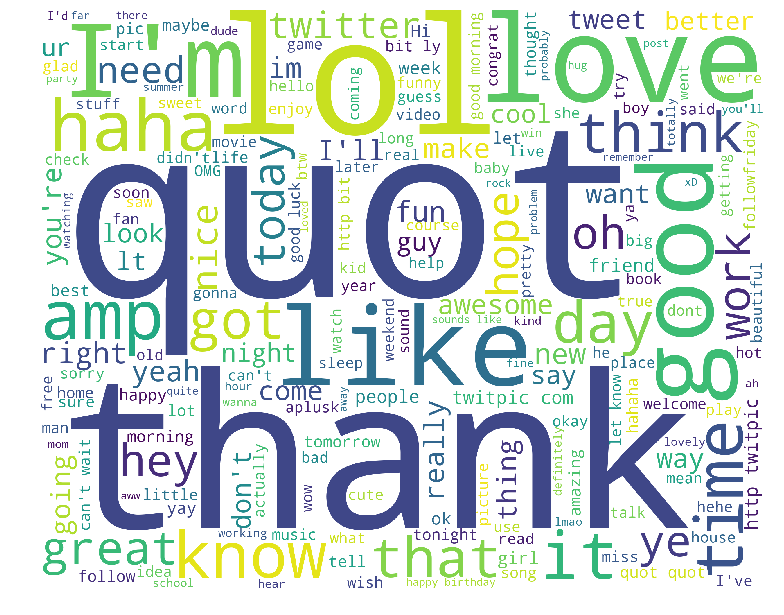

In [72]:
print("Positive words")
wordcloud_draw(data_pos)

## Top Negative Words

Negative words


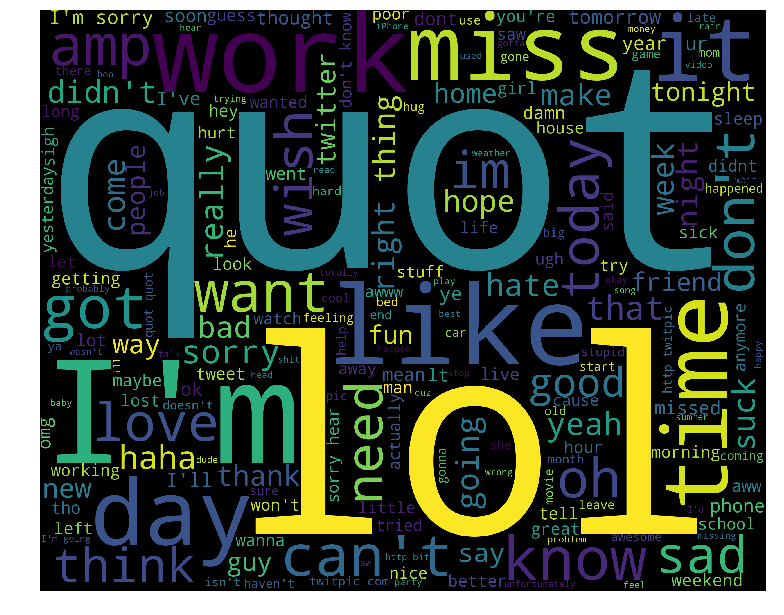

In [73]:
print("Negative words")
wordcloud_draw(data_neg, color = 'black')

# Machine Learning Model (SVM)

### Creating a tokenizer function

In [8]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

### Creating a stemmer function

In [9]:
stemmer = SnowballStemmer("english")

def stem(doc):
    return (stemmer.stem(w) for w in doc)

### Creating a vectorizer

In [ ]:
en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    preprocessor = preprocess,
    lowercase = True,
    ngram_range=(1, 2),
    stop_words = en_stopwords)

### Splitting the data into training and testing sets

In [108]:
train, test = train_test_split(data, test_size=0.2, random_state=1)
X_train = train['SentimentText'].values
X_test = test['SentimentText'].values
y_train = train['Sentiment']
y_test = test['Sentiment']
#X_train = X_train[:20000]
#X_test = X_test[:5000]
#y_train = y_train[:20000]
#y_test = y_test[:5000]

### We are going to use cross validation and grid search to find good hyperparameters for our SVM model. We need to build a pipeline to get features from the validation folds when building each training model.

In [109]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, 
                            kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

print(grid_svm.best_params_)
print(grid_svm.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 544.9min finished


{'svc__C': 0.1}
0.8225349460805557


### Checking how the model (with the best hyperparameters) works on the test data

In [110]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8251729786709477,
 'f1': 0.7855546001719691,
 'acc': 0.7505750575057506,
 'precision': 0.7631139325091881,
 'recall': 0.8093550673281361}

### Plotting False Positive Rate vs True Positive Rate

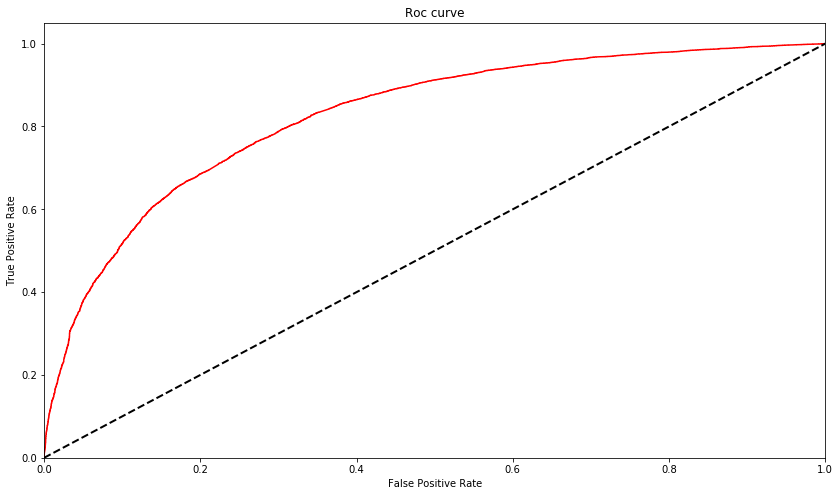

In [111]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

### Checking if the model has some bias or variance problem by ploting its learning curve

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, X_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

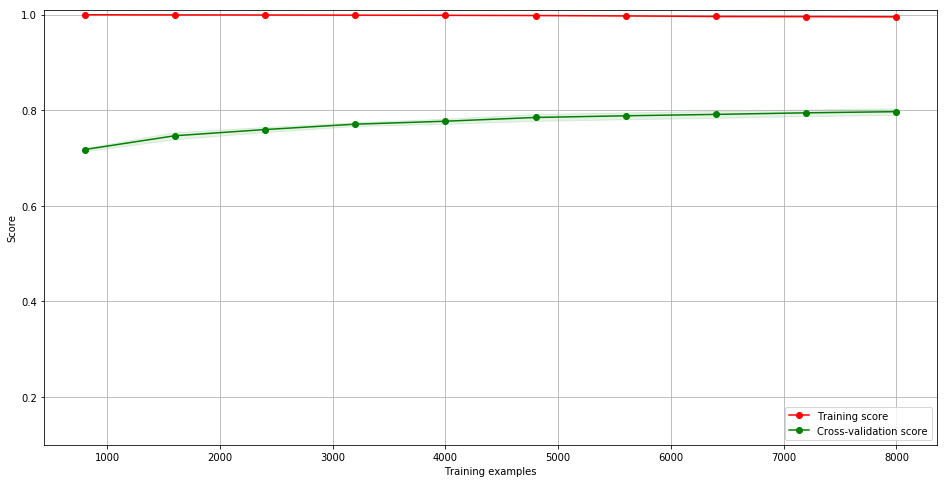

In [34]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt


plot_learning_curve(X_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.1, 1.01), figsize=(16,8))
plt.show()

In [100]:
grid_svm.predict(["I hate it when any athlete appears to tear an ACL on live television."])

array([0])

In [101]:
grid_svm.predict(["friends are leaving me 'cause of this stupid love  http://bit.ly/ZoxZC"])

array([0])

In [105]:
grid_svm.predict(["Thanks, I need all the help i can get."])

array([1])

In [106]:
grid_svm.predict(["@dreamingspires. there r many gr8 science cartoons http://bit.ly/6EW4Q"])

array([1])

In [107]:
grid_svm.predict(["@haugern The servers are now backup, if you experience any more problems then please let me know  Sorry about the delay..."])

array([0])

In [ ]:
grid_svm.predict(["This magazine story just broke my heart at the dentist's office today:  http://tinyurl.com/ngbq2c"])

In [114]:
grid_svm.predict_proba(["I wanted to sleep in this morning but a mean kid through a popsicle stick at me head.I wish I could fly away like those squirrels"])

array([[0.95415974, 0.04584026]])

## CNN Model

In [80]:
from tensorflow import reset_default_graph
reset_default_graph()

import tflearn
from tflearn.data_utils import  to_categorical, pad_sequences
from tflearn.data_utils import VocabularyProcessor 

top_words = 50000

vocab_processor = VocabularyProcessor(160, vocabulary=None)
X_train = list(vocab_processor.transform(X_train)) 
X_test = list(vocab_processor.transform(X_test)) 

X_train = pad_sequences(X_train, maxlen=160, value=0.)
X_test = pad_sequences(X_test, maxlen=160, value=0.)

y_train = to_categorical(y_train, nb_classes=2)
y_test = to_categorical(y_test, nb_classes=2)

net = tflearn.input_data([None, 160])
net = tflearn.embedding(net, input_dim = top_words, output_dim = 128)
net = tflearn.lstm(net, 128, dropout = 0.8)
net = tflearn.fully_connected(net, 2, activation = 'softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, 
                         loss='categorical_crossentropy')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X_train, y_train, validation_set=(X_test, y_test), 
          show_metric=True, batch_size=32)
scores = model.evaluate(X_test, y_test)
print("Acurracy:", scores[0]*100, "%")

Training Step: 6249  | total loss: 0.68497 | time: 79.915s
| Adam | epoch: 010 | loss: 0.68497 - acc: 0.5667 -- iter: 19968/20000
Training Step: 6250  | total loss: 0.68131 | time: 83.652s
| Adam | epoch: 010 | loss: 0.68131 - acc: 0.5787 | val_loss: 0.68752 - val_acc: 0.5556 -- iter: 20000/20000
--
Acurracy: 55.559999999999995 %
